In [1]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader2, Dataset

import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.metrics import classification_report , confusion_matrix, accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
from pandas.core.common import flatten
import copy

In [2]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256,width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=64, width=64),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
batch_size = 256

In [9]:
import glob
import random
train_data_path = 'Datasets/Face_expression/train/' 
test_data_path = 'Datasets/Face_expression/validate/' 
# valid_data_path = 'Datasets/Landscape_Classification/Validation Data/' 

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
train_image_paths = list(flatten(train_image_paths))

random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])


#validation
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 




#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

# print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))
print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths),len(valid_image_paths),len(test_image_paths)))


train_image_path example:  Datasets/Face_expression/train/surprise/31793.jpg
class example:  happy
Train size: 23056
Valid size: 5765
Test size: 7066


In [10]:
valid_image_paths[:10]

['Datasets/Face_expression/train/angry/17964.jpg',
 'Datasets/Face_expression/train/happy/12727.jpg',
 'Datasets/Face_expression/train/fear/5871.jpg',
 'Datasets/Face_expression/train/fear/941.jpg',
 'Datasets/Face_expression/train/sad/33942.jpg',
 'Datasets/Face_expression/train/surprise/32099.jpg',
 'Datasets/Face_expression/train/happy/11868.jpg',
 'Datasets/Face_expression/train/neutral/30395.jpg',
 'Datasets/Face_expression/train/neutral/16824.jpg',
 'Datasets/Face_expression/train/angry/17796.jpg']

In [11]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'happy': 0,
 'sad': 1,
 'fear': 2,
 'surprise': 3,
 'neutral': 4,
 'angry': 5,
 'disgust': 6}

In [12]:
class DatasetFetch(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform :
            image = self.transform(image=image)["image"]     
            Trans = torchvision.transforms.Resize((32,32))
            image = Trans(image)
            
        else:   
            image = torch.tensor(image)
            image = image.permute(2,0,1)
            Trans = torchvision.transforms.Resize((32,32))
            image = Trans(image)

        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = DatasetFetch(train_image_paths)
# train_dataset = DatasetFetch(train_image_paths,train_transforms) #test transforms are applied
test_dataset = DatasetFetch(test_image_paths)
valid_dataset = DatasetFetch(valid_image_paths)

torch.Size([3, 32, 32]) 4


['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

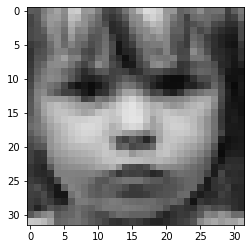

In [13]:
# img = plt.imread('tr.jpeg')
# ar = img.reshape(28,28)
# torch.tensor(img)
x,y = train_dataset[1]
print(x.shape,y)
x= x.permute(1,2,0)

plt.imshow(x)
# train_dataset[0][0].numpy().shape
classes

In [14]:
def plot_loss(loss):
        '''
        Plots the loss curve
        '''
        fig = plt.figure(figsize=(10,10))
        plt.plot(loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show() 

In [15]:
train_loader = DataLoader2(train_dataset,batch_size=batch_size,shuffle=True) 
test_loader = DataLoader2(test_dataset,batch_size=batch_size,shuffle=True) 
valid_loader = DataLoader2(valid_dataset,batch_size=batch_size,shuffle=True) 


In [16]:
def accuracy(train_loader,test_loader,valid_loader=None,model=None,reshape=True):
    train_acc_score, test_acc_score,valid_acc_score = 0.0,0.0,0.0
    model.eval()
    r_pred=[]
    r=[]
    for _,(x,y) in enumerate(train_loader):
        if reshape==True:
            x = x.reshape(x.shape[0],-1)
        scores = model(x)
        _, y_pred = scores.max(1)
        r = r + list(y.numpy())
        r_pred = r_pred + list(y_pred.numpy())
    
    print("\n\n########## Train Data Accuracy ######### \n\n")
    print(classification_report(r,r_pred))
    train_acc_score = accuracy_score(r,r_pred)
    sns.heatmap(confusion_matrix(r,r_pred))
    plt.show()
    
    
    
    r_pred=[]
    r=[]
    for _,(x,y) in enumerate(test_loader):
        if reshape==True:
            x = x.reshape(x.shape[0],-1)
        scores = model(x)
        _, y_pred = scores.max(1)
        r = r + list(y.numpy())
        r_pred = r_pred + list(y_pred.numpy())
    
    print("\n\n########## Test Data Accuracy ######### \n\n") 
    print(classification_report(r,r_pred))
    test_acc_score = accuracy_score(r,r_pred)
    
    sns.heatmap(confusion_matrix(r,r_pred))
    
    if valid_loader is not None:
        r_pred=[]
        r=[]
        for _,(x,y) in enumerate(valid_loader):
            if reshape==True:
                x = x.reshape(x.shape[0],-1)
            scores = model(x)
            _, y_pred = scores.max(1)
            r = r + list(y.numpy())
            r_pred = r_pred + list(y_pred.numpy())
    
        print("\n\n########## Valid Data Accuracy ######### \n\n") 
        print(classification_report(r,r_pred))
        valid_acc_score = accuracy_score(r,r_pred)
        sns.heatmap(confusion_matrix(r,r_pred))
        
    return train_acc_score, test_acc_score,valid_acc_score 


In [17]:
######### CNN Example
class CNN(nn.Module):
    def __init__(self,in_channels=1,num_classes=10):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,16,kernel_size=(2,2),stride=(1,1),padding=(1,1))
        self.conv2 = nn.Conv2d(16,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv3 = nn.Conv2d(16,8,kernel_size=(2,2),stride=(1,1),padding=(1,1))
        self.conv4 = nn.Conv2d(8,8,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.fc1 = nn.Linear(8*8*8,32)        
        self.fc2 = nn.Linear(32,10)        
        self.fc3 = nn.Linear(10,num_classes)        
#         self.fc2 = nn.Linear(20,num_classes)pri
    def forward(self,x):
        x = x.type(dtype=torch.float32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
#         print(x.shape)

        x = x.reshape(x.shape[0],-1)
#         print(x.shape)
        
        x = F.relu(self.fc1(x))     
        x = F.relu(self.fc2(x))     
        x = self.fc3(x)   
#         x = self.fc2(x)       
#         x = self.fc2(x)
        return x

In [18]:
# x = torch.rand((128,3,64,64))
# model_cnn = CNN(in_channels,num_classes)
# scores = model_cnn(x)

In [19]:
in_channels= 3
num_classes= 7
lr = 0.001
epochs = 50

## Model Initialization
model_cnn = CNN(in_channels,num_classes)


## Loss Function and Optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(),lr=lr,weight_decay=0.001)
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)
scheduler = ExponentialLR(optimizer, gamma=0.93)

##### Train The network ##########
# train_loss = []
models=[]
for epoch in range(epochs):
    
    ##train
    train_loss, valid_loss = 0.0, 0.0
    model_cnn.train()
    for batch_id,(x,y) in  tqdm(enumerate(train_loader)):
        
#         x = x.reshape(x.shape[0],-1)
        scores = model_cnn(x)
        loss = loss_func(scores,y)
        
        # backward prop
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
    
    model_cnn.eval()
    for batch_id,(x,y) in  tqdm(enumerate(valid_loader)):
  
        scores = model_cnn(x)
        loss = loss_func(scores, y)
  
        valid_loss += loss.item() 
    d = {'valid_loss': valid_loss/len(valid_loader) ,'model': copy.deepcopy(model_cnn),'train_loss': train_loss/len(train_loader)}
    models.append(d)
    curr_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}\t \
            Training Loss: {train_loss/len(train_loader)}\t \
            Validation Loss:{valid_loss/len(valid_loader)}\t \
            LR:{curr_lr}')
    if(epoch%10==0):
        scheduler.step(epoch)
    
    
    
    
#     print('epoch {}/{}  loss={} '.format(epochs, epoch+1,loss))
# plot_loss(train_loss)
    


        


91it [00:18,  4.90it/s]
23it [00:02, 10.99it/s]
/opt/homebrew/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1	             Training Loss: 1.863099225274809	             Validation Loss:1.787836370260819	             LR:0.001


91it [00:18,  4.97it/s]
23it [00:02, 10.62it/s]


Epoch 2	             Training Loss: 1.722915659894	             Validation Loss:1.6762376142584758	             LR:0.001


91it [00:18,  4.94it/s]
23it [00:02, 10.91it/s]


Epoch 3	             Training Loss: 1.630450814634889	             Validation Loss:1.6327910682429438	             LR:0.001


91it [00:18,  5.03it/s]
23it [00:02, 10.57it/s]


Epoch 4	             Training Loss: 1.5720763416080685	             Validation Loss:1.56243998589723	             LR:0.001


91it [00:18,  5.02it/s]
23it [00:02, 10.63it/s]


Epoch 5	             Training Loss: 1.5266512475170932	             Validation Loss:1.53943219392196	             LR:0.001


91it [00:17,  5.09it/s]
23it [00:02, 10.95it/s]


Epoch 6	             Training Loss: 1.4912976498132224	             Validation Loss:1.5260931253433228	             LR:0.001


91it [00:18,  5.01it/s]
23it [00:02, 10.21it/s]


Epoch 7	             Training Loss: 1.4644188933320097	             Validation Loss:1.5090851576431938	             LR:0.001


91it [00:18,  4.96it/s]
23it [00:02, 10.89it/s]


Epoch 8	             Training Loss: 1.4323428253551105	             Validation Loss:1.480604456818622	             LR:0.001


91it [00:17,  5.14it/s]
23it [00:02, 11.07it/s]


Epoch 9	             Training Loss: 1.4142491882973975	             Validation Loss:1.471031852390455	             LR:0.001


91it [00:17,  5.09it/s]
23it [00:02, 10.89it/s]


Epoch 10	             Training Loss: 1.397783874155401	             Validation Loss:1.4506933689117432	             LR:0.001


91it [00:18,  5.05it/s]
23it [00:02, 10.44it/s]


Epoch 11	             Training Loss: 1.378325132223276	             Validation Loss:1.4390418944151506	             LR:0.001


91it [00:18,  4.97it/s]
23it [00:02, 10.53it/s]


Epoch 12	             Training Loss: 1.343139961525634	             Validation Loss:1.4400782481483791	             LR:0.00048398230717929344


91it [00:18,  5.02it/s]
23it [00:02, 11.06it/s]


Epoch 13	             Training Loss: 1.3325073299827157	             Validation Loss:1.4231267649194468	             LR:0.00048398230717929344


91it [00:17,  5.11it/s]
23it [00:02, 10.51it/s]


Epoch 14	             Training Loss: 1.3227069901896047	             Validation Loss:1.4176884474961653	             LR:0.00048398230717929344


91it [00:18,  4.95it/s]
23it [00:02, 10.75it/s]


Epoch 15	             Training Loss: 1.3128611700875419	             Validation Loss:1.4156265621599944	             LR:0.00048398230717929344


91it [00:18,  4.88it/s]
23it [00:02, 10.84it/s]


Epoch 16	             Training Loss: 1.3103020898588411	             Validation Loss:1.412001521691032	             LR:0.00048398230717929344


91it [00:16,  5.41it/s]
23it [00:01, 16.05it/s]


Epoch 17	             Training Loss: 1.2940769889852504	             Validation Loss:1.4255041661469832	             LR:0.00048398230717929344


91it [00:17,  5.07it/s]
23it [00:02, 10.88it/s]


Epoch 18	             Training Loss: 1.2890439046608222	             Validation Loss:1.3998018140378206	             LR:0.00048398230717929344


91it [00:18,  5.02it/s]
23it [00:01, 11.75it/s]


Epoch 19	             Training Loss: 1.2854402039077255	             Validation Loss:1.4054924819780432	             LR:0.00048398230717929344


91it [00:15,  5.70it/s]
23it [00:01, 15.77it/s]


Epoch 20	             Training Loss: 1.2721002167397804	             Validation Loss:1.4003645440806514	             LR:0.00048398230717929344


91it [00:17,  5.33it/s]
23it [00:01, 15.97it/s]


Epoch 21	             Training Loss: 1.268631208073962	             Validation Loss:1.4196018084235813	             LR:0.00048398230717929344


91it [00:16,  5.51it/s]
23it [00:01, 13.91it/s]


Epoch 22	             Training Loss: 1.2489263932783525	             Validation Loss:1.4008755528408547	             LR:0.00023423887366259195


91it [00:15,  5.69it/s]
23it [00:01, 15.96it/s]


Epoch 23	             Training Loss: 1.241653323173523	             Validation Loss:1.3998775274857231	             LR:0.00023423887366259195


91it [00:15,  5.74it/s]
23it [00:01, 15.97it/s]


Epoch 24	             Training Loss: 1.238412821685875	             Validation Loss:1.395676597304966	             LR:0.00023423887366259195


91it [00:15,  5.72it/s]
23it [00:01, 16.01it/s]


Epoch 25	             Training Loss: 1.23313837653988	             Validation Loss:1.3988090183423914	             LR:0.00023423887366259195


91it [00:16,  5.63it/s]
23it [00:01, 16.05it/s]


Epoch 26	             Training Loss: 1.2327424523594614	             Validation Loss:1.397710893465125	             LR:0.00023423887366259195


91it [00:15,  5.71it/s]
23it [00:01, 15.98it/s]


Epoch 27	             Training Loss: 1.229599762748886	             Validation Loss:1.4034382001213406	             LR:0.00023423887366259195


91it [00:15,  5.73it/s]
23it [00:01, 16.07it/s]


Epoch 28	             Training Loss: 1.2201929511604728	             Validation Loss:1.4117791497189065	             LR:0.00023423887366259195


91it [00:16,  5.51it/s]
23it [00:01, 13.86it/s]


Epoch 29	             Training Loss: 1.2179108334111644	             Validation Loss:1.4046143552531367	             LR:0.00023423887366259195


91it [00:15,  5.71it/s]
23it [00:01, 15.92it/s]


Epoch 30	             Training Loss: 1.2140298990102916	             Validation Loss:1.401926444924396	             LR:0.00023423887366259195


91it [00:16,  5.58it/s]
23it [00:01, 13.50it/s]


Epoch 31	             Training Loss: 1.2122689839247818	             Validation Loss:1.3959162183429883	             LR:0.00023423887366259195


91it [00:17,  5.28it/s]
23it [00:02, 10.55it/s]


Epoch 32	             Training Loss: 1.2017000363423274	             Validation Loss:1.3995586063550867	             LR:0.00011336747050630029


91it [00:18,  4.98it/s]
23it [00:02, 10.94it/s]


Epoch 33	             Training Loss: 1.1983742858027364	             Validation Loss:1.4033646272576374	             LR:0.00011336747050630029


91it [00:17,  5.22it/s]
23it [00:01, 12.20it/s]


Epoch 34	             Training Loss: 1.1943562214191144	             Validation Loss:1.3983479479084844	             LR:0.00011336747050630029


91it [00:17,  5.12it/s]
23it [00:02, 10.61it/s]


Epoch 35	             Training Loss: 1.1935765756355536	             Validation Loss:1.3970638098924055	             LR:0.00011336747050630029


91it [00:19,  4.65it/s]
23it [00:02, 10.41it/s]


Epoch 36	             Training Loss: 1.1918124654790858	             Validation Loss:1.398921303127123	             LR:0.00011336747050630029


91it [00:19,  4.79it/s]
23it [00:02, 10.93it/s]


Epoch 37	             Training Loss: 1.1881816243077372	             Validation Loss:1.4040296699689783	             LR:0.00011336747050630029


91it [02:25,  1.60s/it]
23it [00:02, 10.87it/s]


Epoch 38	             Training Loss: 1.1872622206970886	             Validation Loss:1.3940465864927873	             LR:0.00011336747050630029


91it [00:17,  5.12it/s]
23it [00:02, 11.00it/s]


Epoch 39	             Training Loss: 1.1827273002037635	             Validation Loss:1.408088611519855	             LR:0.00011336747050630029


91it [00:16,  5.57it/s]
23it [00:01, 16.01it/s]


Epoch 40	             Training Loss: 1.1845958324579091	             Validation Loss:1.4066425043603648	             LR:0.00011336747050630029


91it [00:15,  5.72it/s]
23it [00:01, 15.98it/s]


Epoch 41	             Training Loss: 1.1818180424826485	             Validation Loss:1.4017746189366216	             LR:0.00011336747050630029


91it [00:15,  5.73it/s]
23it [00:01, 15.93it/s]


Epoch 42	             Training Loss: 1.1715520305947944	             Validation Loss:1.4003368253293245	             LR:5.486784993471971e-05


91it [00:15,  5.72it/s]
23it [00:01, 16.04it/s]


Epoch 43	             Training Loss: 1.1735494949005463	             Validation Loss:1.4050325932710066	             LR:5.486784993471971e-05


91it [00:15,  5.72it/s]
23it [00:01, 15.91it/s]


Epoch 44	             Training Loss: 1.1708379590904319	             Validation Loss:1.4042812067529429	             LR:5.486784993471971e-05


91it [00:15,  5.70it/s]
23it [00:01, 16.08it/s]


Epoch 45	             Training Loss: 1.1771847546755612	             Validation Loss:1.4041802779487942	             LR:5.486784993471971e-05


91it [02:21,  1.56s/it]
23it [00:01, 14.96it/s]


Epoch 46	             Training Loss: 1.1710668343764086	             Validation Loss:1.407576550608096	             LR:5.486784993471971e-05


91it [00:15,  5.87it/s]
23it [00:01, 16.40it/s]


Epoch 47	             Training Loss: 1.1689389944076538	             Validation Loss:1.403939143471096	             LR:5.486784993471971e-05


91it [00:15,  5.96it/s]
23it [00:01, 16.20it/s]


Epoch 48	             Training Loss: 1.1655958013220147	             Validation Loss:1.403658301933952	             LR:5.486784993471971e-05


91it [00:15,  5.72it/s]
23it [00:01, 15.99it/s]


Epoch 49	             Training Loss: 1.171774141081087	             Validation Loss:1.4026644955510679	             LR:5.486784993471971e-05


91it [00:15,  5.70it/s]
23it [00:01, 15.91it/s]

Epoch 50	             Training Loss: 1.1669185082991045	             Validation Loss:1.405133024505947	             LR:5.486784993471971e-05


############# epoch 1 ############


########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.29      0.96      0.44      5767
           1       0.48      0.00      0.01      3922
           2       0.25      0.05      0.08      3305
           3       0.00      0.00      0.00      2566
           4       0.22      0.16      0.19      3962
           5       0.00      0.00      0.00      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.28     23056
   macro avg       0.18      0.17      0.10     23056
weighted avg       0.23      0.28      0.16     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


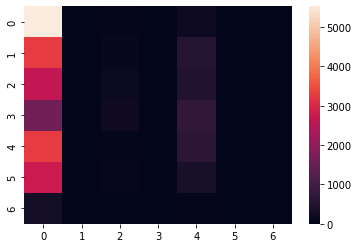



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.29      0.95      0.45      1825
           1       0.71      0.00      0.01      1139
           2       0.24      0.05      0.08      1018
           3       0.00      0.00      0.00       797
           4       0.22      0.16      0.19      1216
           5       0.00      0.00      0.00       960
           6       0.00      0.00      0.00       111

    accuracy                           0.28      7066
   macro avg       0.21      0.17      0.10      7066
weighted avg       0.26      0.28      0.16      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.28      0.96      0.43      1397
           1       0.43      0.00      0.01      1016
           2       0.24      0.04      0.07       798
           3       0.00      0.00      0.00       639
           4       0.24      0.18      0.20      1020
           5       0.00      0.00      0.00       809
           6       0.00      0.00      0.00        86

    accuracy                           0.27      5765
   macro avg       0.17      0.17      0.10      5765
weighted avg       0.22      0.27      0.15      5765

############# epoch 2 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.38      0.83      0.52      5767
           1       0.34      0.12      0.18      3922
           2       0.32      0.03      0.05      3305
           3       0.29      0.64      0.40      2566
           4       0.34      0.26      0.30      3962
           5       0.00      0.00      0.00      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.35     23056
   macro avg       0.24      0.27      0.21     23056
weighted avg       0.29      0.35      0.26     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


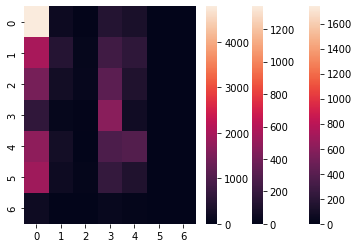



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.40      0.83      0.54      1825
           1       0.33      0.12      0.18      1139
           2       0.29      0.03      0.05      1018
           3       0.28      0.61      0.38       797
           4       0.34      0.27      0.30      1216
           5       0.00      0.00      0.00       960
           6       0.00      0.00      0.00       111

    accuracy                           0.35      7066
   macro avg       0.23      0.27      0.21      7066
weighted avg       0.29      0.35      0.27      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.36      0.83      0.51      1397
           1       0.33      0.11      0.16      1016
           2       0.39      0.04      0.07       798
           3       0.29      0.63      0.39       639
           4       0.34      0.25      0.29      1020
           5       0.00      0.00      0.00       809
           6       0.00      0.00      0.00        86

    accuracy                           0.34      5765
   macro avg       0.24      0.27      0.20      5765
weighted avg       0.29      0.34      0.26      5765

############# epoch 3 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.50      0.66      0.57      5767
           1       0.30      0.27      0.28      3922
           2       0.22      0.42      0.28      3305
           3       0.40      0.54      0.46      2566
           4       0.41      0.20      0.27      3962
           5       0.41      0.02      0.04      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.37     23056
   macro avg       0.32      0.30      0.27     23056
weighted avg       0.38      0.37      0.34     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


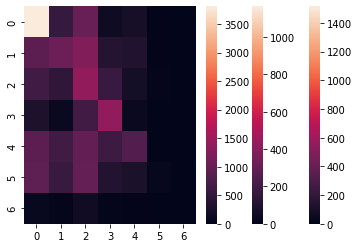



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.52      0.68      0.59      1825
           1       0.29      0.25      0.27      1139
           2       0.22      0.43      0.29      1018
           3       0.38      0.50      0.43       797
           4       0.42      0.21      0.28      1216
           5       0.30      0.01      0.03       960
           6       0.00      0.00      0.00       111

    accuracy                           0.37      7066
   macro avg       0.30      0.30      0.27      7066
weighted avg       0.37      0.37      0.34      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.49      0.67      0.57      1397
           1       0.29      0.25      0.27      1016
           2       0.21      0.43      0.28       798
           3       0.40      0.53      0.46       639
           4       0.38      0.18      0.24      1020
           5       0.30      0.01      0.02       809
           6       0.00      0.00      0.00        86

    accuracy                           0.36      5765
   macro avg       0.30      0.29      0.26      5765
weighted avg       0.35      0.36      0.32      5765

############# epoch 4 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.46      0.79      0.58      5767
           1       0.31      0.34      0.32      3922
           2       0.33      0.11      0.16      3305
           3       0.58      0.47      0.52      2566
           4       0.35      0.49      0.41      3962
           5       0.44      0.02      0.05      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.41     23056
   macro avg       0.35      0.32      0.29     23056
weighted avg       0.40      0.41      0.36     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


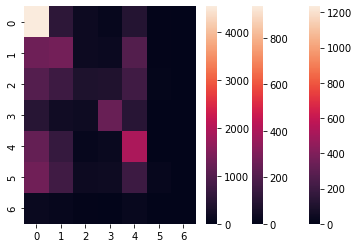



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.47      0.80      0.59      1825
           1       0.29      0.32      0.31      1139
           2       0.31      0.10      0.15      1018
           3       0.55      0.44      0.49       797
           4       0.35      0.49      0.41      1216
           5       0.43      0.02      0.04       960
           6       0.00      0.00      0.00       111

    accuracy                           0.41      7066
   macro avg       0.34      0.31      0.28      7066
weighted avg       0.39      0.41      0.35      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.45      0.80      0.58      1397
           1       0.30      0.33      0.32      1016
           2       0.33      0.11      0.16       798
           3       0.60      0.47      0.53       639
           4       0.33      0.44      0.37      1020
           5       0.46      0.03      0.06       809
           6       0.00      0.00      0.00        86

    accuracy                           0.40      5765
   macro avg       0.35      0.31      0.29      5765
weighted avg       0.40      0.40      0.35      5765

############# epoch 5 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.44      0.86      0.58      5767
           1       0.33      0.30      0.31      3922
           2       0.32      0.20      0.25      3305
           3       0.61      0.47      0.53      2566
           4       0.44      0.35      0.39      3962
           5       0.38      0.13      0.20      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.42     23056
   macro avg       0.36      0.33      0.32     23056
weighted avg       0.41      0.42      0.39     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


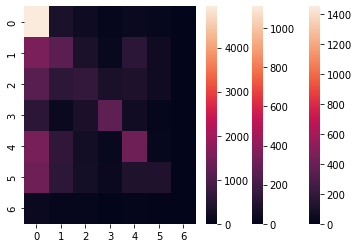



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.45      0.85      0.59      1825
           1       0.31      0.28      0.29      1139
           2       0.27      0.17      0.21      1018
           3       0.57      0.44      0.50       797
           4       0.43      0.35      0.38      1216
           5       0.31      0.11      0.16       960
           6       0.00      0.00      0.00       111

    accuracy                           0.41      7066
   macro avg       0.33      0.31      0.30      7066
weighted avg       0.38      0.41      0.37      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.43      0.85      0.57      1397
           1       0.31      0.27      0.29      1016
           2       0.29      0.19      0.23       798
           3       0.64      0.48      0.55       639
           4       0.39      0.30      0.34      1020
           5       0.36      0.12      0.18       809
           6       0.00      0.00      0.00        86

    accuracy                           0.41      5765
   macro avg       0.35      0.32      0.31      5765
weighted avg       0.39      0.41      0.37      5765

############# epoch 6 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.64      0.64      5767
           1       0.29      0.53      0.38      3922
           2       0.31      0.28      0.29      3305
           3       0.61      0.49      0.55      2566
           4       0.42      0.45      0.44      3962
           5       0.45      0.13      0.20      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.44     23056
   macro avg       0.39      0.36      0.36     23056
weighted avg       0.46      0.44      0.43     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


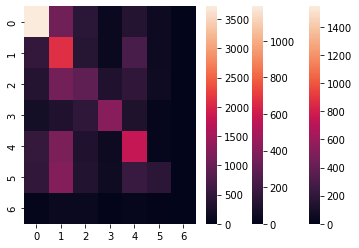



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1825
           1       0.26      0.50      0.35      1139
           2       0.27      0.25      0.26      1018
           3       0.57      0.46      0.51       797
           4       0.40      0.43      0.42      1216
           5       0.39      0.10      0.16       960
           6       0.00      0.00      0.00       111

    accuracy                           0.42      7066
   macro avg       0.36      0.34      0.33      7066
weighted avg       0.43      0.42      0.41      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.60      0.60      1397
           1       0.28      0.52      0.37      1016
           2       0.28      0.26      0.27       798
           3       0.61      0.48      0.54       639
           4       0.38      0.39      0.39      1020
           5       0.41      0.13      0.20       809
           6       0.00      0.00      0.00        86

    accuracy                           0.41      5765
   macro avg       0.37      0.34      0.34      5765
weighted avg       0.43      0.41      0.40      5765

############# epoch 7 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.65      0.64      5767
           1       0.31      0.40      0.35      3922
           2       0.36      0.19      0.25      3305
           3       0.50      0.61      0.55      2566
           4       0.44      0.42      0.43      3962
           5       0.34      0.36      0.35      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.45     23056
   macro avg       0.37      0.38      0.37     23056
weighted avg       0.44      0.45      0.44     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


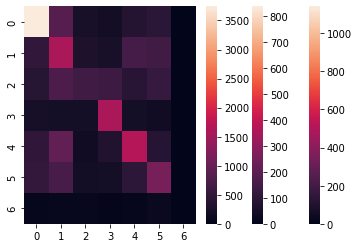



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1825
           1       0.28      0.36      0.31      1139
           2       0.29      0.16      0.20      1018
           3       0.45      0.57      0.50       797
           4       0.42      0.40      0.41      1216
           5       0.28      0.30      0.29       960
           6       0.00      0.00      0.00       111

    accuracy                           0.42      7066
   macro avg       0.34      0.35      0.34      7066
weighted avg       0.41      0.42      0.41      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.63      0.62      1397
           1       0.30      0.38      0.33      1016
           2       0.31      0.19      0.23       798
           3       0.51      0.62      0.56       639
           4       0.40      0.36      0.38      1020
           5       0.32      0.33      0.32       809
           6       0.00      0.00      0.00        86

    accuracy                           0.42      5765
   macro avg       0.35      0.36      0.35      5765
weighted avg       0.41      0.42      0.41      5765

############# epoch 8 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.74      0.66      5767
           1       0.35      0.31      0.33      3922
           2       0.33      0.33      0.33      3305
           3       0.57      0.55      0.56      2566
           4       0.41      0.50      0.45      3962
           5       0.42      0.23      0.30      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.46     23056
   macro avg       0.38      0.38      0.37     23056
weighted avg       0.45      0.46      0.45     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


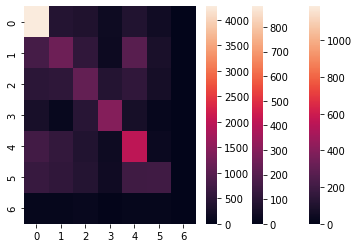



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.57      0.72      0.64      1825
           1       0.32      0.27      0.29      1139
           2       0.28      0.29      0.29      1018
           3       0.53      0.52      0.53       797
           4       0.39      0.48      0.43      1216
           5       0.35      0.18      0.24       960
           6       0.00      0.00      0.00       111

    accuracy                           0.44      7066
   macro avg       0.35      0.35      0.34      7066
weighted avg       0.42      0.44      0.42      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.55      0.70      0.62      1397
           1       0.33      0.29      0.31      1016
           2       0.27      0.30      0.28       798
           3       0.57      0.55      0.56       639
           4       0.38      0.44      0.40      1020
           5       0.39      0.20      0.26       809
           6       0.00      0.00      0.00        86

    accuracy                           0.43      5765
   macro avg       0.36      0.35      0.35      5765
weighted avg       0.41      0.43      0.41      5765

############# epoch 9 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.50      0.85      0.63      5767
           1       0.37      0.28      0.32      3922
           2       0.45      0.13      0.21      3305
           3       0.65      0.52      0.58      2566
           4       0.43      0.46      0.45      3962
           5       0.36      0.35      0.36      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.47     23056
   macro avg       0.40      0.37      0.36     23056
weighted avg       0.45      0.47      0.43     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


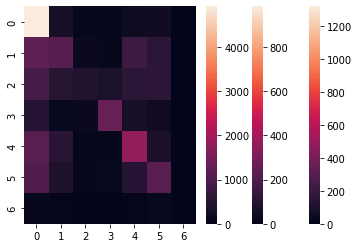



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.50      0.82      0.62      1825
           1       0.32      0.25      0.28      1139
           2       0.36      0.10      0.16      1018
           3       0.62      0.48      0.54       797
           4       0.40      0.44      0.42      1216
           5       0.29      0.28      0.29       960
           6       0.00      0.00      0.00       111

    accuracy                           0.43      7066
   macro avg       0.36      0.34      0.33      7066
weighted avg       0.41      0.43      0.40      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.48      0.84      0.61      1397
           1       0.32      0.25      0.28      1016
           2       0.39      0.12      0.18       798
           3       0.66      0.52      0.58       639
           4       0.39      0.40      0.39      1020
           5       0.33      0.31      0.32       809
           6       0.00      0.00      0.00        86

    accuracy                           0.43      5765
   macro avg       0.37      0.35      0.34      5765
weighted avg       0.42      0.43      0.40      5765

############# epoch 10 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.54      0.84      0.65      5767
           1       0.35      0.39      0.37      3922
           2       0.38      0.22      0.28      3305
           3       0.61      0.56      0.59      2566
           4       0.46      0.44      0.45      3962
           5       0.46      0.24      0.31      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.48     23056
   macro avg       0.40      0.38      0.38     23056
weighted avg       0.46      0.48      0.45     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


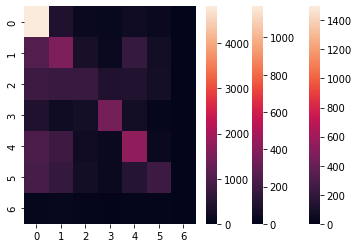



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.53      0.80      0.64      1825
           1       0.31      0.35      0.33      1139
           2       0.32      0.19      0.24      1018
           3       0.57      0.51      0.54       797
           4       0.43      0.43      0.43      1216
           5       0.38      0.18      0.25       960
           6       0.00      0.00      0.00       111

    accuracy                           0.45      7066
   macro avg       0.36      0.35      0.35      7066
weighted avg       0.42      0.45      0.42      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.51      0.81      0.63      1397
           1       0.33      0.36      0.34      1016
           2       0.30      0.18      0.23       798
           3       0.60      0.55      0.58       639
           4       0.41      0.37      0.39      1020
           5       0.39      0.20      0.26       809
           6       0.00      0.00      0.00        86

    accuracy                           0.44      5765
   macro avg       0.36      0.36      0.35      5765
weighted avg       0.42      0.44      0.41      5765

############# epoch 11 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.74      0.68      5767
           1       0.35      0.39      0.37      3922
           2       0.45      0.16      0.23      3305
           3       0.63      0.58      0.60      2566
           4       0.38      0.62      0.47      3962
           5       0.46      0.27      0.34      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.48     23056
   macro avg       0.41      0.39      0.38     23056
weighted avg       0.48      0.48      0.46     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


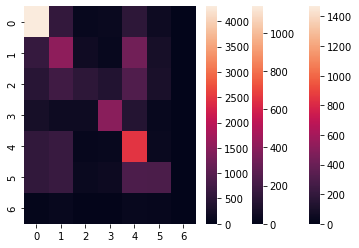



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.72      0.66      1825
           1       0.30      0.34      0.32      1139
           2       0.37      0.12      0.19      1018
           3       0.59      0.51      0.55       797
           4       0.36      0.59      0.45      1216
           5       0.36      0.21      0.27       960
           6       0.00      0.00      0.00       111

    accuracy                           0.45      7066
   macro avg       0.37      0.36      0.35      7066
weighted avg       0.44      0.45      0.42      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.72      0.65      1397
           1       0.31      0.34      0.32      1016
           2       0.36      0.14      0.20       798
           3       0.63      0.57      0.60       639
           4       0.34      0.54      0.42      1020
           5       0.38      0.22      0.28       809
           6       0.00      0.00      0.00        86

    accuracy                           0.44      5765
   macro avg       0.37      0.36      0.35      5765
weighted avg       0.43      0.44      0.42      5765

############# epoch 12 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.69      0.69      5767
           1       0.36      0.37      0.36      3922
           2       0.37      0.29      0.33      3305
           3       0.58      0.64      0.61      2566
           4       0.42      0.59      0.49      3962
           5       0.44      0.29      0.35      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.49     23056
   macro avg       0.41      0.41      0.40     23056
weighted avg       0.48      0.49      0.48     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


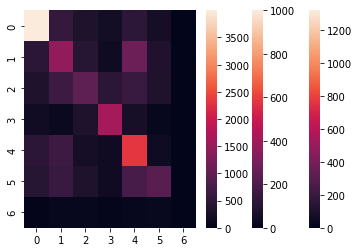



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.67      0.66      1825
           1       0.32      0.34      0.33      1139
           2       0.31      0.26      0.28      1018
           3       0.54      0.59      0.56       797
           4       0.39      0.55      0.46      1216
           5       0.38      0.24      0.30       960
           6       0.00      0.00      0.00       111

    accuracy                           0.46      7066
   macro avg       0.37      0.38      0.37      7066
weighted avg       0.45      0.46      0.45      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.65      0.64      1397
           1       0.33      0.34      0.33      1016
           2       0.29      0.25      0.27       798
           3       0.58      0.62      0.60       639
           4       0.38      0.51      0.43      1020
           5       0.39      0.25      0.31       809
           6       0.00      0.00      0.00        86

    accuracy                           0.45      5765
   macro avg       0.37      0.37      0.37      5765
weighted avg       0.43      0.45      0.44      5765

############# epoch 13 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.77      0.70      5767
           1       0.38      0.35      0.37      3922
           2       0.38      0.30      0.34      3305
           3       0.58      0.66      0.62      2566
           4       0.44      0.54      0.49      3962
           5       0.46      0.28      0.35      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.50     23056
   macro avg       0.41      0.42      0.41     23056
weighted avg       0.48      0.50      0.48     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


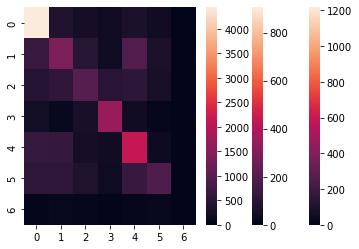



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1825
           1       0.32      0.30      0.31      1139
           2       0.31      0.26      0.29      1018
           3       0.52      0.60      0.56       797
           4       0.41      0.49      0.45      1216
           5       0.38      0.22      0.28       960
           6       0.00      0.00      0.00       111

    accuracy                           0.46      7066
   macro avg       0.36      0.37      0.36      7066
weighted avg       0.43      0.46      0.44      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.74      0.66      1397
           1       0.34      0.32      0.33      1016
           2       0.31      0.26      0.28       798
           3       0.57      0.65      0.61       639
           4       0.40      0.46      0.43      1020
           5       0.41      0.24      0.30       809
           6       0.00      0.00      0.00        86

    accuracy                           0.46      5765
   macro avg       0.37      0.38      0.37      5765
weighted avg       0.44      0.46      0.44      5765

############# epoch 14 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.78      0.70      5767
           1       0.35      0.46      0.40      3922
           2       0.39      0.31      0.35      3305
           3       0.76      0.50      0.60      2566
           4       0.45      0.52      0.48      3962
           5       0.47      0.29      0.36      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.50     23056
   macro avg       0.44      0.41      0.41     23056
weighted avg       0.50      0.50      0.49     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


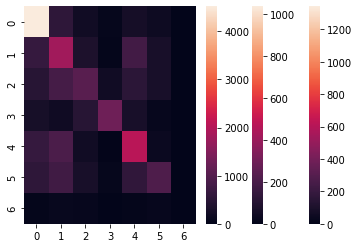



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.75      0.67      1825
           1       0.32      0.42      0.36      1139
           2       0.34      0.28      0.30      1018
           3       0.71      0.43      0.54       797
           4       0.42      0.48      0.45      1216
           5       0.39      0.23      0.29       960
           6       0.00      0.00      0.00       111

    accuracy                           0.46      7066
   macro avg       0.40      0.37      0.37      7066
weighted avg       0.46      0.46      0.45      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.75      0.66      1397
           1       0.32      0.41      0.36      1016
           2       0.32      0.27      0.29       798
           3       0.75      0.49      0.59       639
           4       0.40      0.43      0.41      1020
           5       0.40      0.24      0.30       809
           6       0.00      0.00      0.00        86

    accuracy                           0.45      5765
   macro avg       0.40      0.37      0.37      5765
weighted avg       0.45      0.45      0.44      5765

############# epoch 15 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.83      0.69      5767
           1       0.39      0.37      0.38      3922
           2       0.49      0.20      0.28      3305
           3       0.68      0.60      0.64      2566
           4       0.47      0.50      0.49      3962
           5       0.40      0.42      0.41      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.51     23056
   macro avg       0.43      0.42      0.41     23056
weighted avg       0.49      0.51      0.49     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


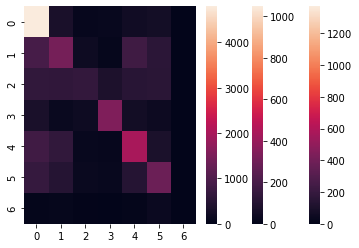



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.56      0.79      0.65      1825
           1       0.34      0.32      0.33      1139
           2       0.40      0.16      0.23      1018
           3       0.61      0.53      0.56       797
           4       0.42      0.46      0.44      1216
           5       0.33      0.33      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.46      7066
   macro avg       0.38      0.37      0.36      7066
weighted avg       0.44      0.46      0.44      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.55      0.80      0.65      1397
           1       0.34      0.31      0.32      1016
           2       0.39      0.17      0.23       798
           3       0.66      0.59      0.62       639
           4       0.41      0.42      0.42      1020
           5       0.35      0.35      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.46      5765
   macro avg       0.38      0.38      0.37      5765
weighted avg       0.44      0.46      0.44      5765

############# epoch 16 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.79      0.70      5767
           1       0.36      0.47      0.41      3922
           2       0.44      0.25      0.32      3305
           3       0.69      0.60      0.64      2566
           4       0.47      0.52      0.49      3962
           5       0.45      0.33      0.38      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.51     23056
   macro avg       0.44      0.42      0.42     23056
weighted avg       0.50      0.51      0.50     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


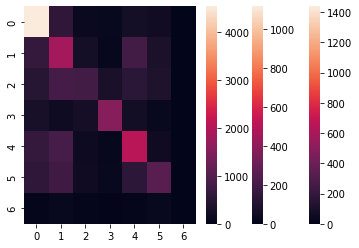



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.75      0.67      1825
           1       0.32      0.42      0.36      1139
           2       0.37      0.20      0.26      1018
           3       0.61      0.52      0.56       797
           4       0.42      0.48      0.45      1216
           5       0.37      0.26      0.30       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.38      0.37      7066
weighted avg       0.45      0.47      0.45      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.75      0.66      1397
           1       0.33      0.42      0.36      1016
           2       0.35      0.22      0.27       798
           3       0.66      0.56      0.61       639
           4       0.40      0.43      0.41      1020
           5       0.39      0.28      0.33       809
           6       0.00      0.00      0.00        86

    accuracy                           0.46      5765
   macro avg       0.39      0.38      0.38      5765
weighted avg       0.45      0.46      0.45      5765

############# epoch 17 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.56      0.86      0.68      5767
           1       0.42      0.30      0.35      3922
           2       0.40      0.31      0.35      3305
           3       0.65      0.64      0.64      2566
           4       0.49      0.48      0.48      3962
           5       0.45      0.33      0.38      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.51     23056
   macro avg       0.42      0.42      0.41     23056
weighted avg       0.49      0.51      0.49     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


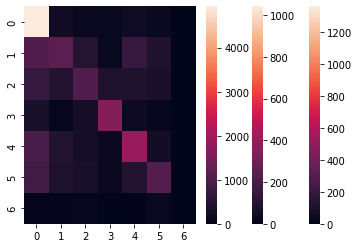



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.54      0.82      0.65      1825
           1       0.36      0.26      0.30      1139
           2       0.32      0.27      0.30      1018
           3       0.57      0.56      0.57       797
           4       0.46      0.44      0.45      1216
           5       0.36      0.26      0.30       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.37      0.37      0.37      7066
weighted avg       0.44      0.47      0.44      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.52      0.83      0.64      1397
           1       0.36      0.25      0.29      1016
           2       0.33      0.28      0.30       798
           3       0.64      0.62      0.63       639
           4       0.42      0.39      0.40      1020
           5       0.39      0.28      0.33       809
           6       0.00      0.00      0.00        86

    accuracy                           0.46      5765
   macro avg       0.38      0.38      0.37      5765
weighted avg       0.43      0.46      0.44      5765

############# epoch 18 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.78      0.71      5767
           1       0.40      0.36      0.38      3922
           2       0.46      0.25      0.32      3305
           3       0.64      0.65      0.64      2566
           4       0.43      0.61      0.50      3962
           5       0.45      0.37      0.40      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.52     23056
   macro avg       0.43      0.43      0.42     23056
weighted avg       0.50      0.52      0.50     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


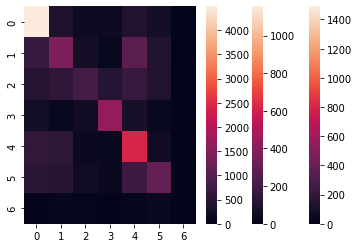



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1825
           1       0.34      0.31      0.32      1139
           2       0.35      0.19      0.24      1018
           3       0.57      0.58      0.58       797
           4       0.39      0.55      0.45      1216
           5       0.36      0.28      0.32       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.37      0.38      0.37      7066
weighted avg       0.44      0.47      0.45      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.73      0.66      1397
           1       0.34      0.30      0.32      1016
           2       0.34      0.20      0.25       798
           3       0.61      0.63      0.62       639
           4       0.39      0.52      0.44      1020
           5       0.38      0.31      0.34       809
           6       0.00      0.00      0.00        86

    accuracy                           0.46      5765
   macro avg       0.38      0.38      0.37      5765
weighted avg       0.44      0.46      0.44      5765

############# epoch 19 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.76      0.72      5767
           1       0.39      0.40      0.39      3922
           2       0.38      0.34      0.36      3305
           3       0.60      0.67      0.63      2566
           4       0.47      0.56      0.51      3962
           5       0.49      0.32      0.39      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.52     23056
   macro avg       0.43      0.44      0.43     23056
weighted avg       0.51      0.52      0.51     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


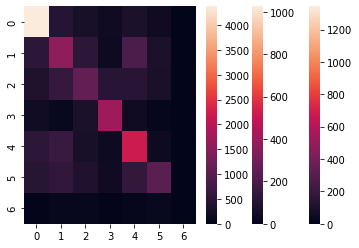



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1825
           1       0.32      0.33      0.32      1139
           2       0.31      0.29      0.30      1018
           3       0.53      0.61      0.57       797
           4       0.42      0.50      0.45      1216
           5       0.38      0.24      0.29       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.37      0.38      0.37      7066
weighted avg       0.45      0.47      0.45      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1397
           1       0.34      0.34      0.34      1016
           2       0.31      0.30      0.31       798
           3       0.57      0.64      0.60       639
           4       0.40      0.46      0.43      1020
           5       0.42      0.26      0.32       809
           6       0.00      0.00      0.00        86

    accuracy                           0.46      5765
   macro avg       0.38      0.39      0.38      5765
weighted avg       0.45      0.46      0.45      5765

############# epoch 20 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.80      0.72      5767
           1       0.38      0.47      0.42      3922
           2       0.47      0.24      0.31      3305
           3       0.64      0.67      0.65      2566
           4       0.48      0.52      0.50      3962
           5       0.48      0.36      0.41      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.53     23056
   macro avg       0.44      0.44      0.43     23056
weighted avg       0.51      0.53      0.51     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


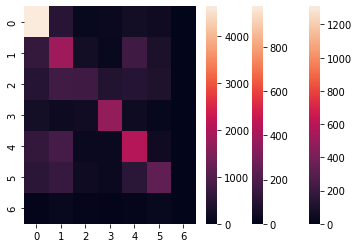



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.75      0.67      1825
           1       0.32      0.40      0.35      1139
           2       0.37      0.19      0.25      1018
           3       0.57      0.58      0.58       797
           4       0.43      0.46      0.45      1216
           5       0.36      0.27      0.31       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.38      0.37      7066
weighted avg       0.45      0.47      0.45      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.75      0.67      1397
           1       0.33      0.42      0.37      1016
           2       0.35      0.19      0.25       798
           3       0.61      0.64      0.62       639
           4       0.41      0.43      0.42      1020
           5       0.40      0.29      0.33       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.38      5765
weighted avg       0.45      0.47      0.45      5765

############# epoch 21 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.58      0.85      0.69      5767
           1       0.41      0.35      0.38      3922
           2       0.49      0.25      0.33      3305
           3       0.77      0.55      0.64      2566
           4       0.50      0.50      0.50      3962
           5       0.40      0.46      0.43      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.52     23056
   macro avg       0.45      0.42      0.42     23056
weighted avg       0.51      0.52      0.50     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


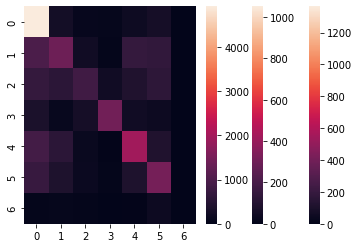



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.55      0.80      0.65      1825
           1       0.36      0.31      0.33      1139
           2       0.37      0.20      0.25      1018
           3       0.69      0.48      0.56       797
           4       0.43      0.44      0.43      1216
           5       0.31      0.35      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.46      7066
   macro avg       0.39      0.37      0.37      7066
weighted avg       0.45      0.46      0.44      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.53      0.82      0.64      1397
           1       0.36      0.30      0.33      1016
           2       0.36      0.20      0.25       798
           3       0.74      0.54      0.62       639
           4       0.44      0.40      0.42      1020
           5       0.34      0.39      0.36       809
           6       0.00      0.00      0.00        86

    accuracy                           0.46      5765
   macro avg       0.40      0.38      0.38      5765
weighted avg       0.45      0.46      0.44      5765

############# epoch 22 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.79      0.72      5767
           1       0.41      0.40      0.40      3922
           2       0.39      0.35      0.37      3305
           3       0.62      0.68      0.65      2566
           4       0.50      0.52      0.51      3962
           5       0.47      0.37      0.41      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.53     23056
   macro avg       0.44      0.45      0.44     23056
weighted avg       0.51      0.53      0.52     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


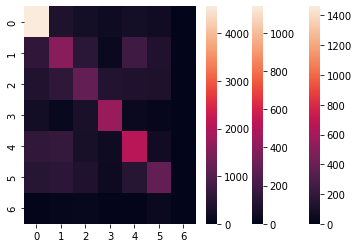



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.74      0.68      1825
           1       0.34      0.33      0.33      1139
           2       0.31      0.29      0.30      1018
           3       0.55      0.61      0.58       797
           4       0.44      0.46      0.45      1216
           5       0.36      0.27      0.31       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.37      0.38      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.73      0.67      1397
           1       0.35      0.34      0.35      1016
           2       0.32      0.31      0.31       798
           3       0.58      0.65      0.61       639
           4       0.43      0.43      0.43      1020
           5       0.38      0.28      0.32       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.38      0.39      0.38      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 23 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.79      0.73      5767
           1       0.40      0.42      0.41      3922
           2       0.43      0.33      0.38      3305
           3       0.69      0.64      0.66      2566
           4       0.50      0.54      0.52      3962
           5       0.45      0.42      0.44      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.54     23056
   macro avg       0.45      0.45      0.45     23056
weighted avg       0.52      0.54      0.53     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


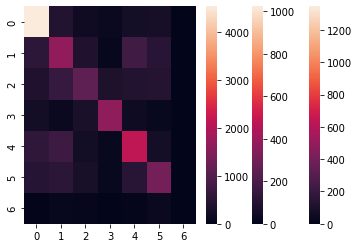



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.73      0.68      1825
           1       0.33      0.35      0.34      1139
           2       0.33      0.26      0.29      1018
           3       0.61      0.56      0.58       797
           4       0.43      0.47      0.45      1216
           5       0.35      0.31      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.38      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.72      0.66      1397
           1       0.34      0.35      0.35      1016
           2       0.32      0.27      0.29       798
           3       0.65      0.61      0.63       639
           4       0.42      0.43      0.42      1020
           5       0.35      0.32      0.33       809
           6       0.00      0.00      0.00        86

    accuracy                           0.46      5765
   macro avg       0.38      0.39      0.38      5765
weighted avg       0.45      0.46      0.45      5765

############# epoch 24 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.69      0.78      0.73      5767
           1       0.39      0.49      0.43      3922
           2       0.44      0.31      0.36      3305
           3       0.70      0.64      0.67      2566
           4       0.50      0.55      0.52      3962
           5       0.48      0.38      0.42      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.54     23056
   macro avg       0.46      0.45      0.45     23056
weighted avg       0.53      0.54      0.53     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


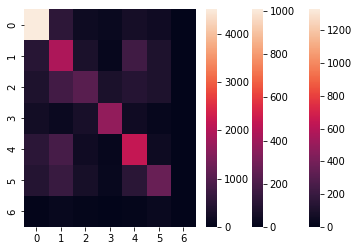



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.72      0.68      1825
           1       0.31      0.41      0.36      1139
           2       0.33      0.24      0.28      1018
           3       0.61      0.55      0.58       797
           4       0.43      0.48      0.46      1216
           5       0.37      0.27      0.31       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.39      0.38      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1397
           1       0.33      0.42      0.37      1016
           2       0.34      0.27      0.30       798
           3       0.66      0.60      0.63       639
           4       0.42      0.43      0.42      1020
           5       0.39      0.30      0.34       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.40      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 25 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.82      0.72      5767
           1       0.40      0.44      0.42      3922
           2       0.48      0.29      0.36      3305
           3       0.73      0.62      0.67      2566
           4       0.51      0.51      0.51      3962
           5       0.44      0.46      0.45      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.54     23056
   macro avg       0.46      0.45      0.45     23056
weighted avg       0.53      0.54      0.53     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


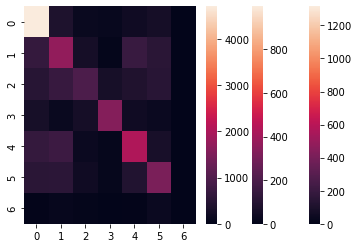



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.76      0.67      1825
           1       0.34      0.38      0.36      1139
           2       0.36      0.22      0.27      1018
           3       0.63      0.52      0.57       797
           4       0.43      0.45      0.44      1216
           5       0.33      0.33      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.39      0.38      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.77      0.67      1397
           1       0.34      0.37      0.36      1016
           2       0.36      0.24      0.29       798
           3       0.70      0.58      0.64       639
           4       0.43      0.41      0.42      1020
           5       0.35      0.35      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.40      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 26 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.81      0.73      5767
           1       0.39      0.48      0.43      3922
           2       0.46      0.30      0.37      3305
           3       0.72      0.63      0.67      2566
           4       0.50      0.54      0.52      3962
           5       0.50      0.38      0.43      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.54     23056
   macro avg       0.46      0.45      0.45     23056
weighted avg       0.53      0.54      0.53     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


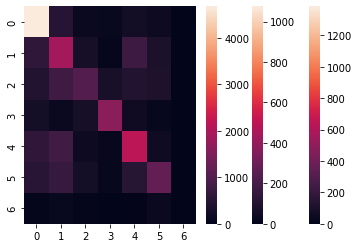



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.75      0.68      1825
           1       0.32      0.41      0.36      1139
           2       0.35      0.23      0.27      1018
           3       0.61      0.53      0.57       797
           4       0.44      0.48      0.46      1216
           5       0.38      0.27      0.32       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.39      0.38      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.75      0.67      1397
           1       0.33      0.41      0.36      1016
           2       0.36      0.25      0.30       798
           3       0.68      0.59      0.63       639
           4       0.42      0.43      0.42      1020
           5       0.39      0.29      0.33       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.40      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 27 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.81      0.72      5767
           1       0.42      0.42      0.42      3922
           2       0.47      0.29      0.36      3305
           3       0.67      0.67      0.67      2566
           4       0.50      0.57      0.53      3962
           5       0.47      0.41      0.44      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.54     23056
   macro avg       0.45      0.45      0.45     23056
weighted avg       0.53      0.54      0.53     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


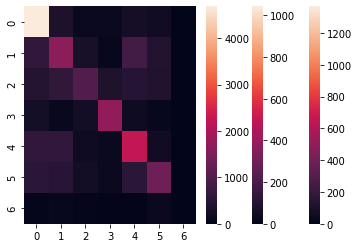



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.75      0.68      1825
           1       0.33      0.34      0.33      1139
           2       0.35      0.22      0.27      1018
           3       0.57      0.58      0.58       797
           4       0.42      0.49      0.46      1216
           5       0.36      0.30      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.38      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.76      0.67      1397
           1       0.35      0.34      0.34      1016
           2       0.36      0.25      0.29       798
           3       0.63      0.62      0.63       639
           4       0.41      0.46      0.43      1020
           5       0.37      0.32      0.34       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 28 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.82      0.73      5767
           1       0.43      0.38      0.41      3922
           2       0.41      0.37      0.39      3305
           3       0.64      0.69      0.67      2566
           4       0.53      0.51      0.52      3962
           5       0.47      0.41      0.44      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.54     23056
   macro avg       0.45      0.45      0.45     23056
weighted avg       0.52      0.54      0.53     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


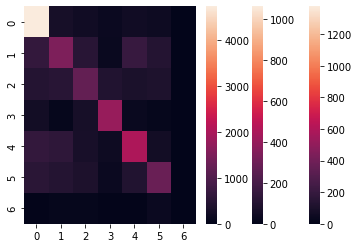



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.76      0.67      1825
           1       0.34      0.31      0.32      1139
           2       0.32      0.29      0.30      1018
           3       0.55      0.61      0.58       797
           4       0.45      0.44      0.44      1216
           5       0.37      0.29      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.76      0.66      1397
           1       0.36      0.32      0.34      1016
           2       0.32      0.31      0.32       798
           3       0.58      0.64      0.61       639
           4       0.43      0.40      0.42      1020
           5       0.38      0.31      0.34       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.38      0.39      0.39      5765
weighted avg       0.45      0.47      0.45      5765

############# epoch 29 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.81      0.73      5767
           1       0.43      0.40      0.42      3922
           2       0.42      0.36      0.39      3305
           3       0.65      0.68      0.67      2566
           4       0.52      0.54      0.53      3962
           5       0.49      0.40      0.44      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.55     23056
   macro avg       0.45      0.46      0.45     23056
weighted avg       0.53      0.55      0.53     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


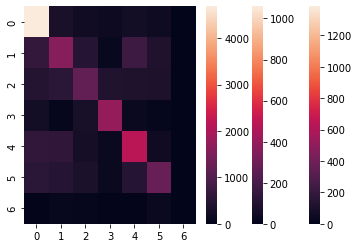



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.75      0.67      1825
           1       0.34      0.31      0.33      1139
           2       0.32      0.29      0.30      1018
           3       0.57      0.60      0.58       797
           4       0.44      0.47      0.46      1216
           5       0.38      0.28      0.32       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.76      0.67      1397
           1       0.36      0.34      0.35      1016
           2       0.33      0.31      0.32       798
           3       0.60      0.65      0.62       639
           4       0.43      0.42      0.43      1020
           5       0.40      0.30      0.34       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.40      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 30 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.80      0.73      5767
           1       0.42      0.45      0.43      3922
           2       0.47      0.30      0.37      3305
           3       0.68      0.68      0.68      2566
           4       0.51      0.55      0.53      3962
           5       0.46      0.44      0.45      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.55     23056
   macro avg       0.46      0.46      0.45     23056
weighted avg       0.53      0.55      0.54     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


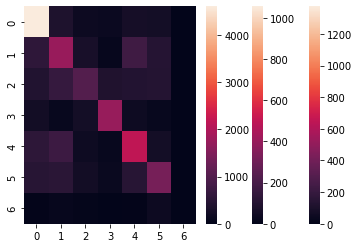



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1825
           1       0.33      0.36      0.35      1139
           2       0.35      0.23      0.28      1018
           3       0.58      0.59      0.59       797
           4       0.42      0.46      0.44      1216
           5       0.34      0.32      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1397
           1       0.35      0.37      0.36      1016
           2       0.34      0.24      0.28       798
           3       0.64      0.63      0.64       639
           4       0.43      0.43      0.43      1020
           5       0.36      0.33      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 31 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.81      0.73      5767
           1       0.42      0.43      0.42      3922
           2       0.46      0.30      0.36      3305
           3       0.67      0.68      0.67      2566
           4       0.52      0.54      0.53      3962
           5       0.46      0.45      0.46      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.55     23056
   macro avg       0.46      0.46      0.45     23056
weighted avg       0.53      0.55      0.54     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


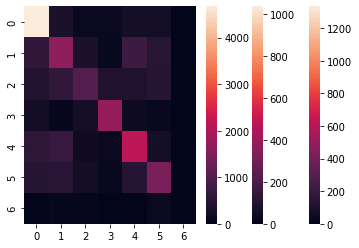



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.74      0.67      1825
           1       0.34      0.34      0.34      1139
           2       0.35      0.24      0.28      1018
           3       0.57      0.59      0.58       797
           4       0.43      0.46      0.45      1216
           5       0.35      0.33      0.34       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.75      0.67      1397
           1       0.35      0.35      0.35      1016
           2       0.35      0.26      0.30       798
           3       0.63      0.64      0.63       639
           4       0.43      0.43      0.43      1020
           5       0.37      0.34      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 32 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.80      0.74      5767
           1       0.42      0.47      0.44      3922
           2       0.47      0.32      0.38      3305
           3       0.72      0.65      0.68      2566
           4       0.52      0.54      0.53      3962
           5       0.45      0.47      0.46      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.55     23056
   macro avg       0.47      0.46      0.46     23056
weighted avg       0.54      0.55      0.54     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


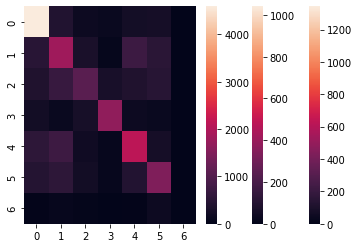



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1825
           1       0.32      0.37      0.35      1139
           2       0.34      0.24      0.28      1018
           3       0.61      0.55      0.58       797
           4       0.44      0.46      0.45      1216
           5       0.33      0.34      0.34       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.38      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1397
           1       0.35      0.39      0.37      1016
           2       0.34      0.25      0.29       798
           3       0.67      0.60      0.63       639
           4       0.43      0.42      0.43      1020
           5       0.35      0.35      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 33 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.82      0.73      5767
           1       0.42      0.45      0.44      3922
           2       0.45      0.36      0.40      3305
           3       0.74      0.63      0.68      2566
           4       0.53      0.52      0.52      3962
           5       0.47      0.43      0.45      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.55     23056
   macro avg       0.47      0.46      0.46     23056
weighted avg       0.54      0.55      0.54     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


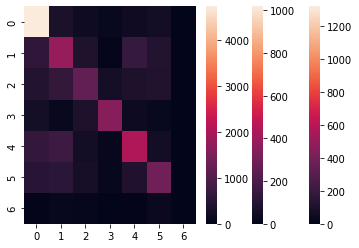



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.75      0.68      1825
           1       0.33      0.36      0.35      1139
           2       0.32      0.27      0.29      1018
           3       0.62      0.53      0.57       797
           4       0.45      0.45      0.45      1216
           5       0.35      0.31      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.38      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.76      0.67      1397
           1       0.35      0.37      0.36      1016
           2       0.34      0.30      0.32       798
           3       0.69      0.58      0.63       639
           4       0.43      0.40      0.41      1020
           5       0.37      0.33      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.40      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 34 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.70      0.79      0.74      5767
           1       0.42      0.47      0.44      3922
           2       0.46      0.34      0.39      3305
           3       0.71      0.66      0.68      2566
           4       0.51      0.56      0.53      3962
           5       0.47      0.44      0.46      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.47      0.46     23056
weighted avg       0.54      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


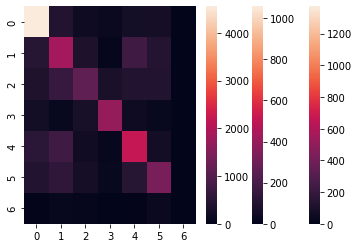



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.72      0.68      1825
           1       0.33      0.37      0.35      1139
           2       0.34      0.26      0.29      1018
           3       0.60      0.56      0.58       797
           4       0.43      0.48      0.45      1216
           5       0.35      0.32      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1397
           1       0.34      0.38      0.36      1016
           2       0.34      0.27      0.30       798
           3       0.66      0.62      0.64       639
           4       0.42      0.43      0.43      1020
           5       0.37      0.33      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 35 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.81      0.74      5767
           1       0.42      0.47      0.44      3922
           2       0.46      0.35      0.40      3305
           3       0.72      0.65      0.69      2566
           4       0.52      0.54      0.53      3962
           5       0.48      0.43      0.46      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.46      0.46     23056
weighted avg       0.54      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


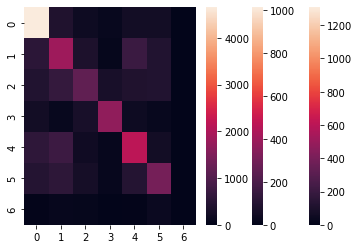



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.73      0.68      1825
           1       0.33      0.37      0.35      1139
           2       0.34      0.26      0.29      1018
           3       0.61      0.55      0.58       797
           4       0.44      0.47      0.46      1216
           5       0.36      0.32      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.39      0.39      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1397
           1       0.35      0.38      0.36      1016
           2       0.34      0.28      0.31       798
           3       0.66      0.61      0.63       639
           4       0.43      0.42      0.43      1020
           5       0.37      0.32      0.34       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 36 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.69      0.80      0.74      5767
           1       0.41      0.51      0.45      3922
           2       0.46      0.34      0.39      3305
           3       0.72      0.65      0.68      2566
           4       0.53      0.53      0.53      3962
           5       0.49      0.42      0.45      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.46      0.46     23056
weighted avg       0.55      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


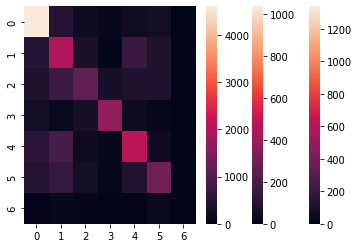



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.73      0.68      1825
           1       0.32      0.41      0.36      1139
           2       0.34      0.25      0.29      1018
           3       0.61      0.54      0.58       797
           4       0.45      0.46      0.45      1216
           5       0.36      0.30      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.39      0.39      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1397
           1       0.33      0.42      0.37      1016
           2       0.34      0.27      0.30       798
           3       0.67      0.60      0.63       639
           4       0.43      0.41      0.42      1020
           5       0.38      0.31      0.34       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.40      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 37 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.69      0.80      0.74      5767
           1       0.43      0.43      0.43      3922
           2       0.46      0.34      0.39      3305
           3       0.66      0.69      0.68      2566
           4       0.51      0.57      0.54      3962
           5       0.48      0.44      0.46      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.46      0.47      0.46     23056
weighted avg       0.54      0.56      0.54     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


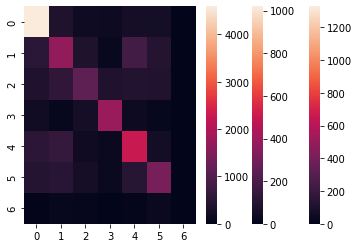



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.73      0.68      1825
           1       0.34      0.33      0.33      1139
           2       0.34      0.25      0.29      1018
           3       0.57      0.60      0.58       797
           4       0.43      0.48      0.45      1216
           5       0.34      0.31      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1397
           1       0.35      0.35      0.35      1016
           2       0.34      0.28      0.31       798
           3       0.62      0.64      0.63       639
           4       0.42      0.44      0.43      1020
           5       0.37      0.32      0.34       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 38 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.69      0.80      0.74      5767
           1       0.42      0.47      0.45      3922
           2       0.48      0.31      0.38      3305
           3       0.71      0.67      0.69      2566
           4       0.52      0.56      0.54      3962
           5       0.46      0.47      0.46      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.47      0.47     23056
weighted avg       0.55      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


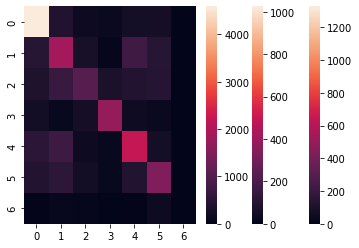



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.72      0.68      1825
           1       0.33      0.37      0.35      1139
           2       0.35      0.24      0.28      1018
           3       0.59      0.57      0.58       797
           4       0.44      0.48      0.46      1216
           5       0.33      0.32      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1397
           1       0.33      0.38      0.36      1016
           2       0.36      0.25      0.29       798
           3       0.66      0.62      0.64       639
           4       0.42      0.43      0.42      1020
           5       0.35      0.34      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 39 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.83      0.73      5767
           1       0.44      0.42      0.43      3922
           2       0.46      0.35      0.40      3305
           3       0.70      0.67      0.68      2566
           4       0.55      0.52      0.53      3962
           5       0.45      0.48      0.47      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.47      0.46     23056
weighted avg       0.54      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


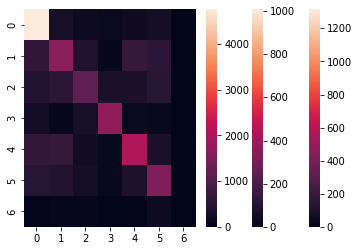



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.75      0.67      1825
           1       0.34      0.31      0.32      1139
           2       0.34      0.27      0.30      1018
           3       0.59      0.57      0.58       797
           4       0.45      0.44      0.45      1216
           5       0.33      0.35      0.34       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.38      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.76      0.67      1397
           1       0.35      0.34      0.35      1016
           2       0.34      0.29      0.31       798
           3       0.65      0.62      0.63       639
           4       0.44      0.39      0.41      1020
           5       0.35      0.36      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 40 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.69      0.80      0.74      5767
           1       0.43      0.44      0.44      3922
           2       0.48      0.31      0.38      3305
           3       0.67      0.69      0.68      2566
           4       0.50      0.59      0.54      3962
           5       0.48      0.44      0.46      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.46      0.47      0.46     23056
weighted avg       0.54      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


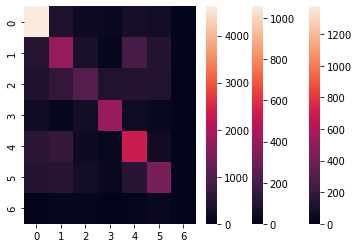



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.73      0.68      1825
           1       0.33      0.34      0.34      1139
           2       0.36      0.23      0.29      1018
           3       0.58      0.59      0.59       797
           4       0.42      0.50      0.46      1216
           5       0.35      0.32      0.34       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1397
           1       0.35      0.35      0.35      1016
           2       0.35      0.24      0.28       798
           3       0.62      0.64      0.63       639
           4       0.41      0.46      0.43      1020
           5       0.37      0.33      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 41 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.70      0.80      0.74      5767
           1       0.42      0.48      0.45      3922
           2       0.48      0.31      0.38      3305
           3       0.68      0.69      0.68      2566
           4       0.53      0.55      0.54      3962
           5       0.47      0.46      0.47      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.47      0.47     23056
weighted avg       0.55      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


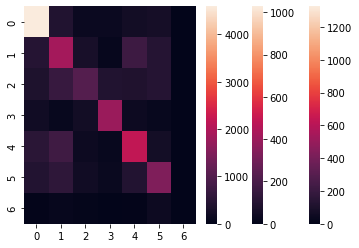



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.72      0.68      1825
           1       0.33      0.37      0.35      1139
           2       0.35      0.23      0.28      1018
           3       0.58      0.60      0.59       797
           4       0.44      0.47      0.45      1216
           5       0.34      0.33      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1397
           1       0.34      0.39      0.36      1016
           2       0.35      0.24      0.29       798
           3       0.62      0.64      0.63       639
           4       0.43      0.42      0.42      1020
           5       0.36      0.34      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 42 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.81      0.74      5767
           1       0.44      0.44      0.44      3922
           2       0.48      0.34      0.40      3305
           3       0.69      0.68      0.69      2566
           4       0.52      0.57      0.54      3962
           5       0.48      0.45      0.47      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.47      0.47     23056
weighted avg       0.55      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


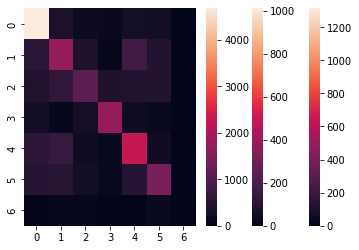



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.73      0.68      1825
           1       0.34      0.34      0.34      1139
           2       0.35      0.25      0.29      1018
           3       0.59      0.58      0.58       797
           4       0.43      0.49      0.46      1216
           5       0.35      0.32      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1397
           1       0.35      0.35      0.35      1016
           2       0.34      0.27      0.30       798
           3       0.64      0.63      0.64       639
           4       0.41      0.43      0.42      1020
           5       0.37      0.33      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 43 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.81      0.74      5767
           1       0.43      0.46      0.45      3922
           2       0.47      0.35      0.40      3305
           3       0.68      0.69      0.69      2566
           4       0.54      0.54      0.54      3962
           5       0.48      0.46      0.47      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.47      0.47     23056
weighted avg       0.55      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


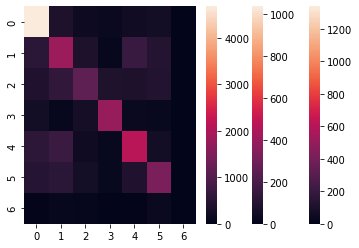



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.74      0.68      1825
           1       0.33      0.35      0.34      1139
           2       0.34      0.26      0.29      1018
           3       0.58      0.59      0.59       797
           4       0.44      0.45      0.45      1216
           5       0.35      0.32      0.34       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1397
           1       0.35      0.37      0.36      1016
           2       0.34      0.28      0.31       798
           3       0.63      0.64      0.63       639
           4       0.43      0.40      0.42      1020
           5       0.37      0.34      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.40      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 44 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.70      0.80      0.75      5767
           1       0.42      0.50      0.46      3922
           2       0.48      0.34      0.40      3305
           3       0.76      0.63      0.69      2566
           4       0.52      0.56      0.54      3962
           5       0.48      0.46      0.47      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.48      0.47      0.47     23056
weighted avg       0.55      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


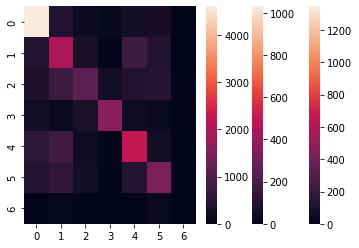



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.72      0.68      1825
           1       0.32      0.39      0.35      1139
           2       0.35      0.25      0.29      1018
           3       0.62      0.53      0.57       797
           4       0.43      0.48      0.45      1216
           5       0.35      0.33      0.34       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.39      0.38      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1397
           1       0.33      0.40      0.36      1016
           2       0.35      0.25      0.29       798
           3       0.69      0.59      0.63       639
           4       0.42      0.43      0.42      1020
           5       0.36      0.33      0.34       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.40      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 45 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.71      0.79      0.75      5767
           1       0.43      0.49      0.46      3922
           2       0.45      0.37      0.41      3305
           3       0.70      0.68      0.69      2566
           4       0.54      0.53      0.53      3962
           5       0.48      0.46      0.47      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.47      0.47     23056
weighted avg       0.55      0.56      0.56     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


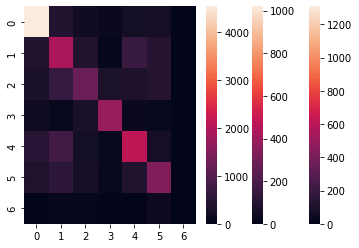



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1825
           1       0.33      0.37      0.35      1139
           2       0.33      0.28      0.30      1018
           3       0.59      0.57      0.58       797
           4       0.45      0.45      0.45      1216
           5       0.35      0.33      0.34       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1397
           1       0.35      0.39      0.37      1016
           2       0.32      0.29      0.31       798
           3       0.64      0.62      0.63       639
           4       0.44      0.40      0.42      1020
           5       0.37      0.34      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 46 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.81      0.74      5767
           1       0.44      0.46      0.45      3922
           2       0.46      0.36      0.41      3305
           3       0.70      0.67      0.68      2566
           4       0.53      0.55      0.54      3962
           5       0.49      0.43      0.46      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.47      0.47     23056
weighted avg       0.55      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


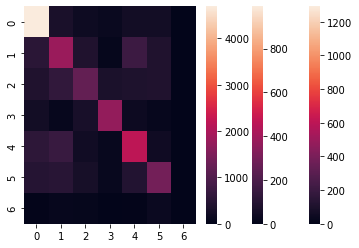



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.74      0.67      1825
           1       0.33      0.34      0.33      1139
           2       0.33      0.27      0.30      1018
           3       0.59      0.57      0.58       797
           4       0.43      0.46      0.45      1216
           5       0.36      0.31      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.38      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1397
           1       0.34      0.36      0.35      1016
           2       0.34      0.30      0.32       798
           3       0.64      0.63      0.64       639
           4       0.43      0.42      0.43      1020
           5       0.38      0.32      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.40      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 47 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.69      0.81      0.74      5767
           1       0.43      0.46      0.45      3922
           2       0.49      0.33      0.40      3305
           3       0.71      0.68      0.69      2566
           4       0.52      0.56      0.54      3962
           5       0.47      0.46      0.47      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.56     23056
   macro avg       0.47      0.47      0.47     23056
weighted avg       0.55      0.56      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


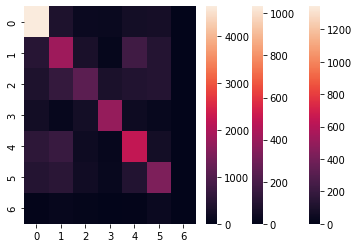



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.73      0.67      1825
           1       0.33      0.35      0.34      1139
           2       0.35      0.24      0.29      1018
           3       0.60      0.57      0.58       797
           4       0.44      0.48      0.46      1216
           5       0.34      0.33      0.34       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1397
           1       0.35      0.37      0.36      1016
           2       0.35      0.25      0.29       798
           3       0.65      0.62      0.63       639
           4       0.42      0.43      0.42      1020
           5       0.36      0.34      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.45      0.47      0.46      5765

############# epoch 48 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.69      0.81      0.74      5767
           1       0.43      0.49      0.46      3922
           2       0.48      0.35      0.40      3305
           3       0.75      0.64      0.69      2566
           4       0.54      0.54      0.54      3962
           5       0.47      0.47      0.47      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.57     23056
   macro avg       0.48      0.47      0.47     23056
weighted avg       0.55      0.57      0.56     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


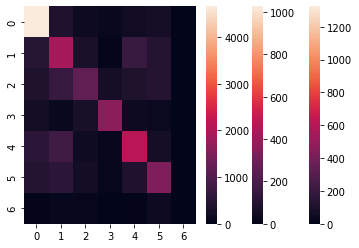



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.73      0.68      1825
           1       0.33      0.37      0.35      1139
           2       0.34      0.25      0.29      1018
           3       0.61      0.53      0.57       797
           4       0.44      0.45      0.45      1216
           5       0.34      0.34      0.34       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.38      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.74      0.67      1397
           1       0.34      0.39      0.37      1016
           2       0.35      0.26      0.30       798
           3       0.68      0.59      0.63       639
           4       0.43      0.41      0.42      1020
           5       0.35      0.35      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 49 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.69      0.81      0.75      5767
           1       0.43      0.48      0.45      3922
           2       0.47      0.37      0.41      3305
           3       0.71      0.67      0.69      2566
           4       0.54      0.54      0.54      3962
           5       0.48      0.46      0.47      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.57     23056
   macro avg       0.47      0.47      0.47     23056
weighted avg       0.55      0.57      0.56     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


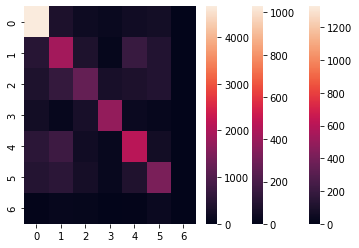



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.73      0.68      1825
           1       0.33      0.36      0.34      1139
           2       0.33      0.27      0.30      1018
           3       0.60      0.56      0.58       797
           4       0.45      0.45      0.45      1216
           5       0.35      0.33      0.34       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.46      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1397
           1       0.35      0.38      0.36      1016
           2       0.34      0.29      0.31       798
           3       0.65      0.62      0.63       639
           4       0.43      0.40      0.42      1020
           5       0.37      0.34      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.46      0.47      0.46      5765

############# epoch 50 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.69      0.81      0.74      5767
           1       0.43      0.47      0.45      3922
           2       0.48      0.34      0.40      3305
           3       0.70      0.68      0.69      2566
           4       0.52      0.56      0.54      3962
           5       0.48      0.46      0.47      3184
           6       0.00      0.00      0.00       350

    accuracy                           0.57     23056
   macro avg       0.47      0.47      0.47     23056
weighted avg       0.55      0.57      0.55     23056



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


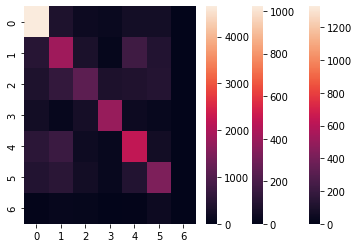



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.73      0.67      1825
           1       0.32      0.35      0.34      1139
           2       0.35      0.25      0.29      1018
           3       0.59      0.58      0.58       797
           4       0.44      0.47      0.45      1216
           5       0.34      0.32      0.33       960
           6       0.00      0.00      0.00       111

    accuracy                           0.47      7066
   macro avg       0.38      0.39      0.38      7066
weighted avg       0.45      0.47      0.46      7066



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.73      0.66      1397
           1       0.34      0.37      0.36      1016
           2       0.34      0.26      0.30       798
           3       0.64      0.62      0.63       639
           4       0.42      0.42      0.42      1020
           5       0.36      0.34      0.35       809
           6       0.00      0.00      0.00        86

    accuracy                           0.47      5765
   macro avg       0.39      0.39      0.39      5765
weighted avg       0.45      0.47      0.46      5765



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


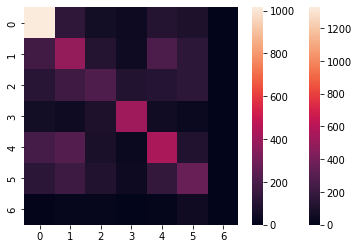

In [20]:
test_acc,train_acc,valid_acc= [],[],[]
for epoch in range(epochs):
    print("############# epoch {} ############".format(epoch+1))
    
    train_acc_score, test_acc_score,valid_acc_score = accuracy(train_loader,test_loader,valid_loader,models[epoch]['model'],reshape=False)
    train_acc.append(train_acc_score)
    test_acc.append(test_acc_score)
    valid_acc.append(valid_acc_score)


    

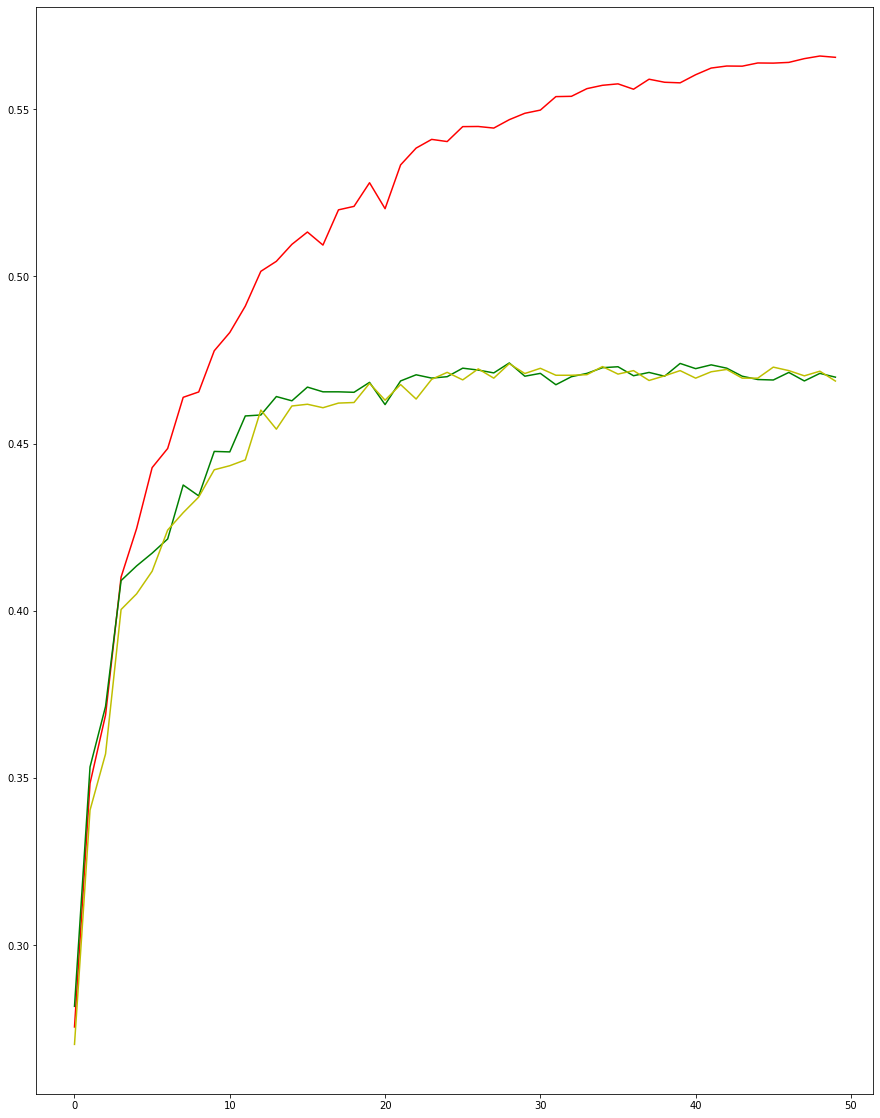

In [21]:
fig = plt.figure(figsize=(15,20))
plt.plot(range(epochs),train_acc,'-r')
plt.plot(range(epochs),test_acc,'-g')
plt.plot(range(epochs),valid_acc,'-y')

In [22]:
for epoch in range(epochs):
    print(f'Epoch: {epoch}\n \
    Validation Accracy: {valid_acc[epoch]}\n \
    test Accracy: {test_acc[epoch]}\n \
    train Accracy: {train_acc[epoch]}')

Epoch: 0
     Validation Accracy: 0.27025151777970513
     test Accracy: 0.28163034248514013
     train Accracy: 0.2754597501734906
Epoch: 1
     Validation Accracy: 0.34032957502168254
     test Accracy: 0.3532408717803566
     train Accracy: 0.3483258154059681
Epoch: 2
     Validation Accracy: 0.3571552471812663
     test Accracy: 0.3713557882819134
     train Accracy: 0.3687977099236641
Epoch: 3
     Validation Accracy: 0.40034692107545533
     test Accracy: 0.40900084913671103
     train Accracy: 0.41004510756419155
Epoch: 4
     Validation Accracy: 0.40503035559410233
     test Accracy: 0.4133880554769318
     train Accracy: 0.42457494795281053
Epoch: 5
     Validation Accracy: 0.41179531656548135
     test Accracy: 0.4172091706764789
     train Accracy: 0.4427914642609299
Epoch: 6
     Validation Accracy: 0.4241110147441457
     test Accracy: 0.4214548542315313
     train Accracy: 0.44851665510062455
Epoch: 7
     Validation Accracy: 0.4293148308759757
     test Accracy: 0.437588